In [1]:
import pandas as pd
from pathlib import Path
import xarray as xr

In [2]:
filename = Path('data', 'Heitronics-Apogee_Comparison_irt60s.dat')

### Here is the first 6 lines of the file:

"TOA5","Heitronics-Apogee Comparison","CR1000X","9292","CR1000X.Std.03.01","CPU:Apogee-Heitronics-Analog.CR1X","46927","irt60s"

"TIMESTAMP","RECORD","sfc_ir_temp_Avg","sfc_ir_temp_Std","sfc_a_ir_temp_Avg","sfc_a_ir_temp_Std","logger_temp","logger_volt","logger_LiBat"

"TS","RN","Kelvin","Kelvin","Kelvin","Kelvin","Celsius","Volt","Volt"

"","","Avg","Std","Avg","Std","Smp","Smp","Smp"

"2022-07-15 18:57:00",0,318.3,0.062,318.1,0.342,26.34,13.64,3.93

"2022-07-15 18:58:00",1,318.1,0.347,317.7,1.452,26.38,13.64,3.931

We can read the file with no keywords and see what we get. It will do the best it can to read the file making some default assumptions. Not bad for knowing nothing about the data file. But there are some issues. So we need to understand what keywords we should use and the values for those keywords.

In [3]:
df = pd.read_csv(filename)
df[:5]

,TOA5,Heitronics-Apogee Comparison,CR1000X,9292,CR1000X.Std.03.01,CPU:Apogee-Heitronics-Analog.CR1X,46927,irt60s
TIMESTAMP,RECORD,sfc_ir_temp_Avg,sfc_ir_temp_Std,sfc_a_ir_temp_Avg,sfc_a_ir_temp_Std,logger_temp,logger_volt,logger_LiBat
TS,RN,Kelvin,Kelvin,Kelvin,Kelvin,Celsius,Volt,Volt
NaN,NaN,Avg,Std,Avg,Std,Smp,Smp,Smp
2022-07-15 18:57:00,0,318.3,0.062,318.1,0.342,26.34,13.64,3.93
2022-07-15 18:58:00,1,318.1,0.347,317.7,1.452,26.38,13.64,3.931


- Even though the delimiter was assumed correctly to be a comma we should be explicit.
- We should indicate what rows should be skipped. There is some metadata about the values that we can skip over.
- There is a column of dates and we can have Pandas do the work of parsing that for us.
- We should index on time so we can do that during the read in process.
- We can indicate what row contains the header names. Notice skiprows is applied first so the header is second row in the file, but we state it is the first row in the file after skiprows is applied.

In [4]:
df = pd.read_csv(filename, delimiter=',', skiprows=[0, 2, 3],
                 header=0, parse_dates=[0], index_col=[0])
df[:5]

,RECORD,sfc_ir_temp_Avg,sfc_ir_temp_Std,sfc_a_ir_temp_Avg,sfc_a_ir_temp_Std,logger_temp,logger_volt,logger_LiBat
TIMESTAMP,,,,,,,,
2022-07-15 18:57:00,0,318.3,0.062,318.1,0.342,26.34,13.64,3.930
2022-07-15 18:58:00,1,318.1,0.347,317.7,1.452,26.38,13.64,3.931
2022-07-15 18:59:00,2,318.5,0.201,318.1,0.587,26.40,13.64,3.931
2022-07-15 19:00:00,3,318.2,0.214,319.2,0.875,26.42,13.64,3.931
2022-07-15 19:01:00,4,317.6,0.322,317.4,1.086,26.43,13.64,3.931


Since Pandas does not have a native place to hold the metadata we can convert the Pandas Dataframe to an Xarray Dataset and add the metadata to the DataArrays.

Before we do that we can clean up the index column name. CF convention indicates the dimension and coordinate name for time dimension should match. This allows Xarray tools to work correctly. Suggested name to use is 'time'.

In [5]:
df.index.name = 'time'  # Set the index name to 'time'
ds = df.to_xarray()  # Convert from Pandas Dataframe to Xarray Dataset
ds

<xarray.Dataset>
Dimensions:            (time: 7426)
Coordinates:
  * time               (time) datetime64[ns] 2022-07-15T18:57:00 ... 2022-07-...
Data variables:
    RECORD             (time) int64 0 1 2 3 4 5 ... 7421 7422 7423 7424 7425
    sfc_ir_temp_Avg    (time) float64 318.3 318.1 318.5 ... 308.6 308.6 308.7
    sfc_ir_temp_Std    (time) float64 0.062 0.347 0.201 ... 0.065 0.053 0.047
    sfc_a_ir_temp_Avg  (time) float64 318.1 317.7 318.1 ... 308.2 308.3 308.3
    sfc_a_ir_temp_Std  (time) float64 0.342 1.452 0.587 ... 0.041 0.024 0.028
    logger_temp        (time) float64 26.34 26.38 26.4 26.42 ... 24.3 24.3 24.3
    logger_volt        (time) float64 13.64 13.64 13.64 ... 13.7 13.71 13.67
    logger_LiBat       (time) float64 3.93 3.931 3.931 ... 3.932 3.939 3.937

Since the units and long name are in the header of the .dat file we can read the .dat file as ASCII and apply those values to the DataArray attributes.

In [6]:
# We will use the with: block controller to automatically close the file when we exit the loop
with open(filename, 'r') as file_handle:  # Open the file and assign the file handle
    for ii, line in enumerate(file_handle):  # Loop over and read each line of the file
        line = line.rstrip()  # Strip off any extra white spaces or returns from the strings.
        line = line.replace('"', '')  # Remove quote character by replacing the quote with nothing.
        if ii == 0:  # Read first line
            long_name = line.split(',')  # Convert string into list of strings and assign to variable
        elif ii == 2:  # Read the thrid line
            units = line.split(',')  # Convert string into list of strings and assign to variable     
        elif ii >= 4:  # After we get the header information exit loop.
            break

# Print the units and long_name lists so we can see what was read.
print("long_name:", long_name, len(long_name))
print("units:", units, len(units))

long_name: ['TOA5', 'Heitronics-Apogee Comparison', 'CR1000X', '9292', 'CR1000X.Std.03.01', 'CPU:Apogee-Heitronics-Analog.CR1X', '46927', 'irt60s'] 8
units: ['TS', 'RN', 'Kelvin', 'Kelvin', 'Kelvin', 'Kelvin', 'Celsius', 'Volt', 'Volt'] 9


In [7]:
# units has TIMESTAMP unit. But we made this the index
# so we need to drop first value.
units
units = units[1: ]

We can use the header information we read to populate the long_name and units attributes. We will do this by looping over the data variable names add appllying the values we just read. We are making an assumption that everything is correctly applied since the order of reading the data is the same as the order of reading the metadata.

In [8]:
# Loop over the variable names in the Dataset
for ii, var_name in enumerate(ds.data_vars):
    ds[var_name].attrs['long_name'] = long_name[ii]  # Set the long_name attribute
    ds[var_name].attrs['units'] = units[ii]  # Set the units attribute

In [9]:
ds['sfc_ir_temp_Avg']

<xarray.DataArray 'sfc_ir_temp_Avg' (time: 7426)>
array([318.3, 318.1, 318.5, ..., 308.6, 308.6, 308.7])
Coordinates:
  * time     (time) datetime64[ns] 2022-07-15T18:57:00 ... 2022-07-20T22:42:00
Attributes:
    long_name:  Heitronics-Apogee Comparison
    units:      Kelvin

The RECORD column is not needed so we can drop it from the Dataset. By waiting until the end of this process we do not need to accomidate the RECORD column in our loops. Often it is easier to do more work and then clean up at the end to ensure everyting lines up correctly. Now we have a Xarary Dataset with correctly formatted coordinates, variables and metadata. We can go do great things now.

In [10]:
del ds['RECORD']
ds

<xarray.Dataset>
Dimensions:            (time: 7426)
Coordinates:
  * time               (time) datetime64[ns] 2022-07-15T18:57:00 ... 2022-07-...
Data variables:
    sfc_ir_temp_Avg    (time) float64 318.3 318.1 318.5 ... 308.6 308.6 308.7
    sfc_ir_temp_Std    (time) float64 0.062 0.347 0.201 ... 0.065 0.053 0.047
    sfc_a_ir_temp_Avg  (time) float64 318.1 317.7 318.1 ... 308.2 308.3 308.3
    sfc_a_ir_temp_Std  (time) float64 0.342 1.452 0.587 ... 0.041 0.024 0.028
    logger_temp        (time) float64 26.34 26.38 26.4 26.42 ... 24.3 24.3 24.3
    logger_volt        (time) float64 13.64 13.64 13.64 ... 13.7 13.71 13.67
    logger_LiBat       (time) float64 3.93 3.931 3.931 ... 3.932 3.939 3.937

We can also manually update the attributes to a better value if the one provided in the data file is not quite right.

In [11]:
ds['sfc_ir_temp_Avg'].attrs['long_name'] = 'Heitronics Surface Temperature, 1 minute average'
ds['sfc_ir_temp_Std'].attrs['long_name'] = 'Heitronics Surface Temperature, 1 minute standard deviation'
ds['sfc_a_ir_temp_Avg'].attrs['long_name'] = 'Apogee Surface Temperature, 1 minute average'
ds['sfc_a_ir_temp_Std'].attrs['long_name'] = 'Apogee Surface Temperature, 1 minute standard deviation'
ds['logger_temp'].attrs['long_name'] = 'Logger Internal Temperature'
ds['logger_volt'].attrs['long_name'] = 'Logger Internal Voltage'
ds['logger_LiBat'].attrs['long_name'] = 'Logger Lithium Battery Voltage'

We can also add metadata to the global attributes section.

In [12]:
ds.attrs['Location'] = 'SGP E41'

Since there is no location information in the .dat file we can add that. Notice we are creating Xarray DataArray and then assigning that DataArray to a variable in the Dataset. Since the values we are adding are scalars we only need to provide the value and attributes. Do not provide "dims".

In [13]:
ds["lat"] = xr.DataArray(36.87956, {'standard_name': 'latitude'})
ds["lon"] = xr.DataArray(-97.08645, {'standard_name': 'longitude'})
ds["lat"]

<xarray.DataArray 'lat' ()>
array(36.87956)
Coordinates:
    standard_name  <U8 'latitude'

If the units of the values are not how we want them we can use Pint to perform the conversion. Just need to extract the values, perform conversion and put back, not forgetting to update the units attribute.

In [14]:
import pint

ureg = pint.UnitRegistry()  # Set up the regestry object.

desired_unit = 'degC'
var_names = ['sfc_ir_temp_Avg', 'sfc_a_ir_temp_Avg']  #, 'sfc_ir_temp_Std', 'sfc_a_ir_temp_Std']
for var_name in var_names:
    data = ds[var_name].values  # Get the data from Xarray object.
    # Get the variable unit from the Dataset. Convert to lower case because Pint does not
    # recognize "Kelvin" only "kelvin"
    variable_units = ds[var_name].attrs['units'].lower()
    # Convert the data to Pint object that contains the magnitude and unit
    data = data * ureg.parse_expression(variable_units)  
    # Convert from "kelvin" to "degC"
    data = data.to(ureg.parse_expression(desired_unit))
    ds[var_name].values = data  # Put data back into Dataset
    ds[var_name].attrs['units'] = desired_unit  # Update units in Dataset

Let's make a plot of the data.

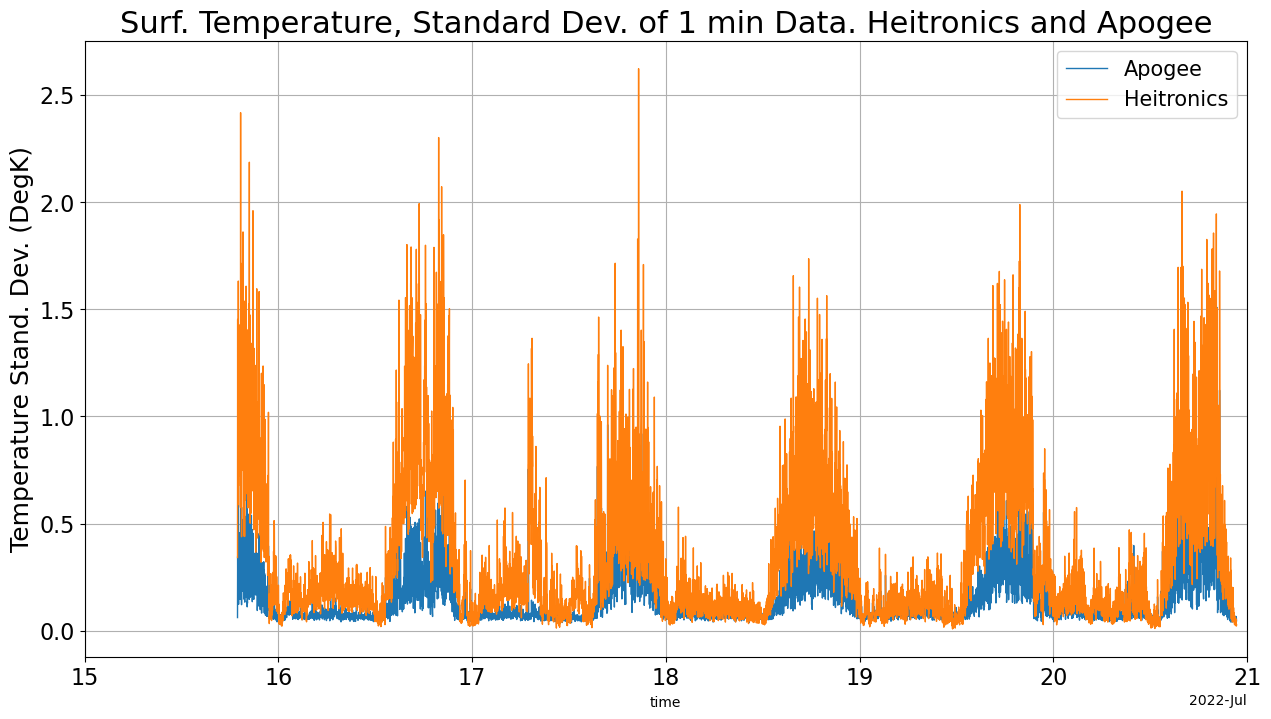

In [15]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize = (15, 8))
al, = ds['sfc_ir_temp_Std'].plot(ax = ax, linewidth=1.0, label='Apogee')
hl, = ds['sfc_a_ir_temp_Std'].plot(ax = ax, linewidth=1.0, label='Heitronics')

ax.set_title('Surf. Temperature, Standard Dev. of 1 min Data. Heitronics and Apogee', fontsize = 22)
ax.legend(handles=[al, hl], fontsize = 15)
ax.grid()
plt.ylabel('Temperature Stand. Dev. (DegK)')

# Set plot range limits
begday = ds['time'].values[0].astype('datetime64[D]')
endday = ds['time'].values[-1].astype('datetime64[D]') + 1
plt.xlim(begday, endday)
# plt.ylim(0, 3.5)

plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
ax.xaxis.label.set_fontsize(10)
ax.yaxis.label.set_fontsize(18)